In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 320

ng =12

ng_adju = (/ 0 , 0 /) 

ng_refs = (/ 3 , 3 , 6 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 20

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.5 , 1.5 , 1.5 , 1.5/

data wgt
     &     /0.2 , 0.2 , 0.2 , 0.2,
     &     0.2 , 0.2 , 0.2 , 0.2,
     &     0.65 , 0.65 , 0.65 , 0.65/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

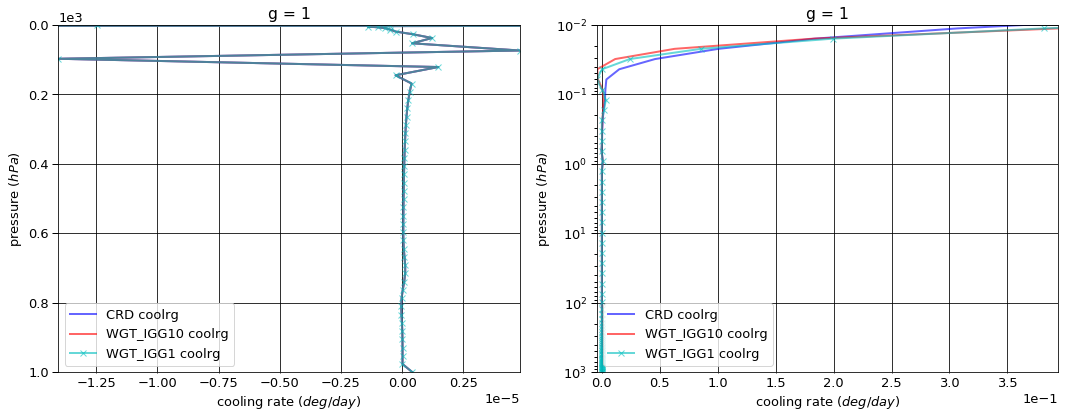

# Figure: cooling rate g-group 2

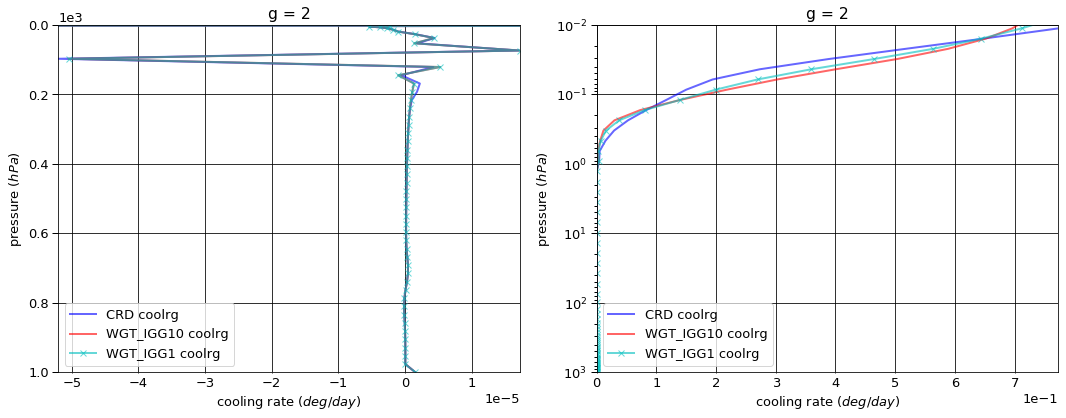

# Figure: cooling rate g-group 3

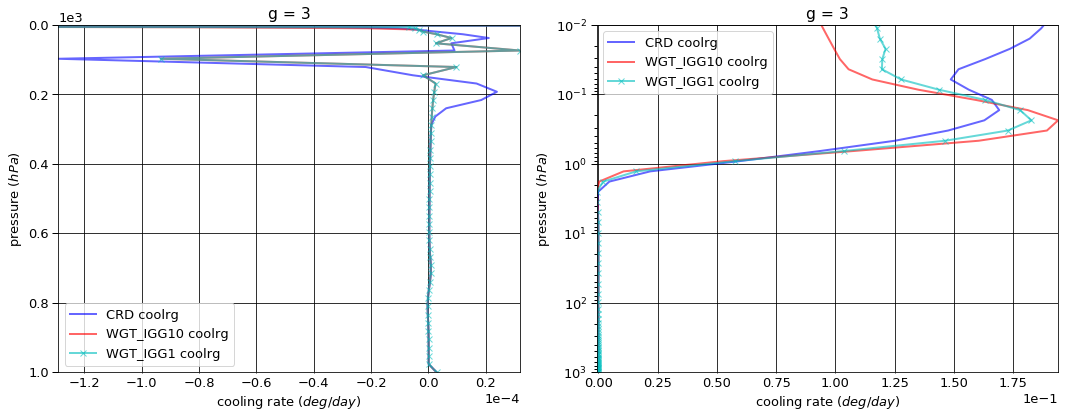

# Figure: cooling rate g-group 4

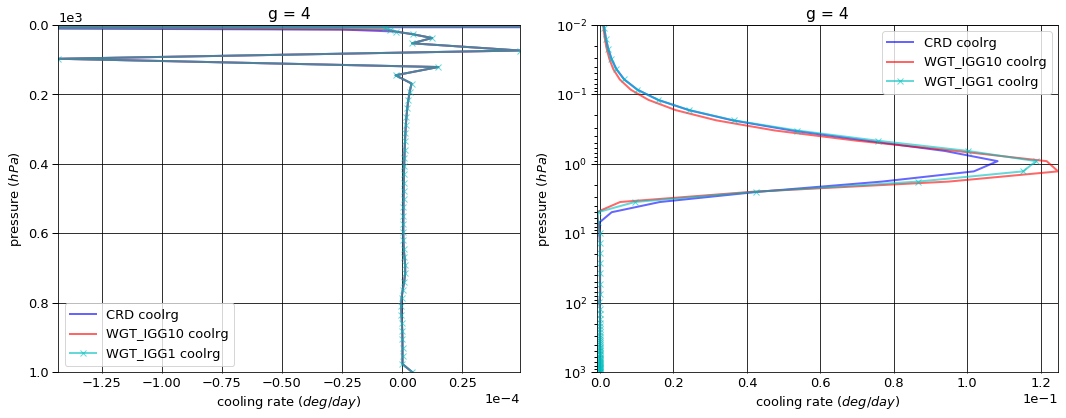

# Figure: cooling rate g-group 5

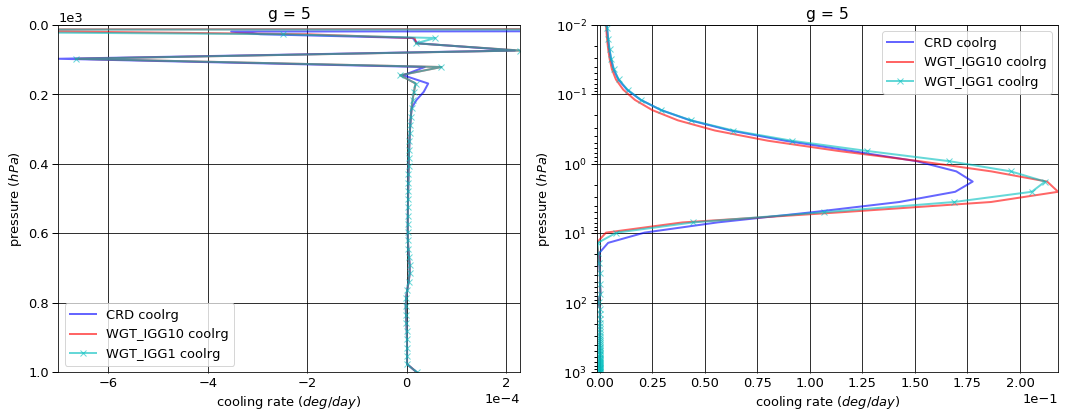

# Figure: cooling rate g-group 6

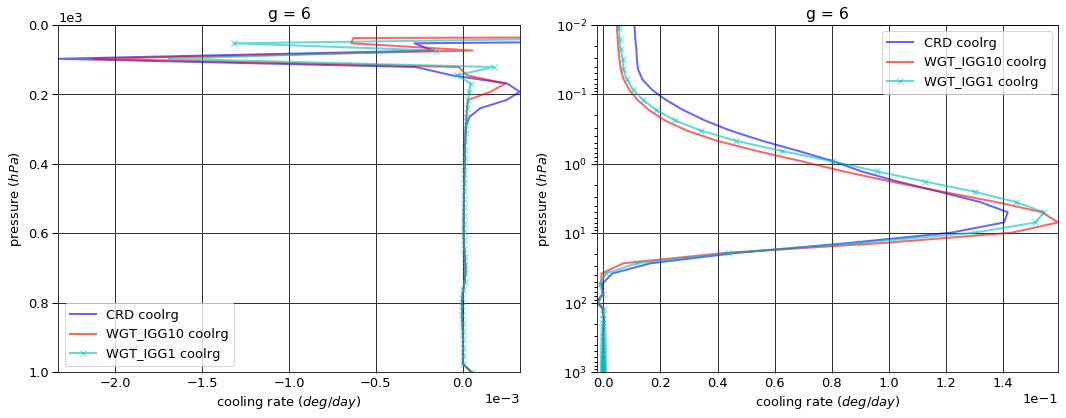

# Figure: cooling rate g-group 7

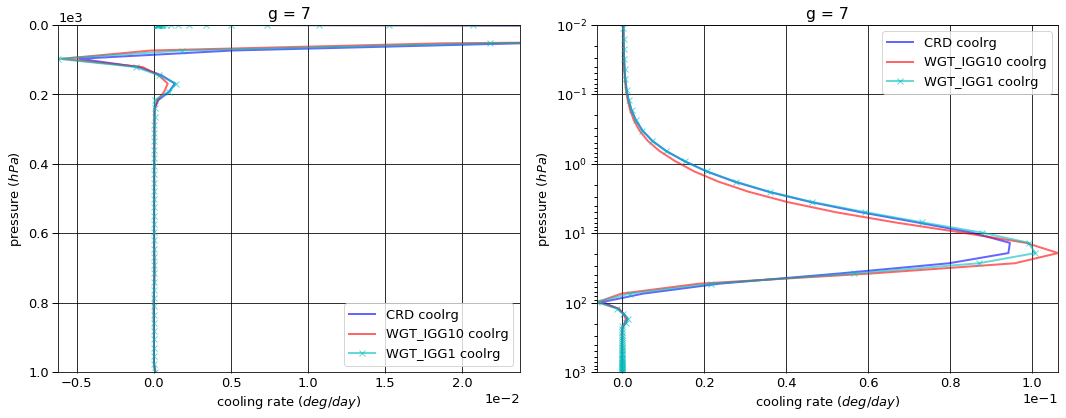

# Figure: cooling rate g-group 8

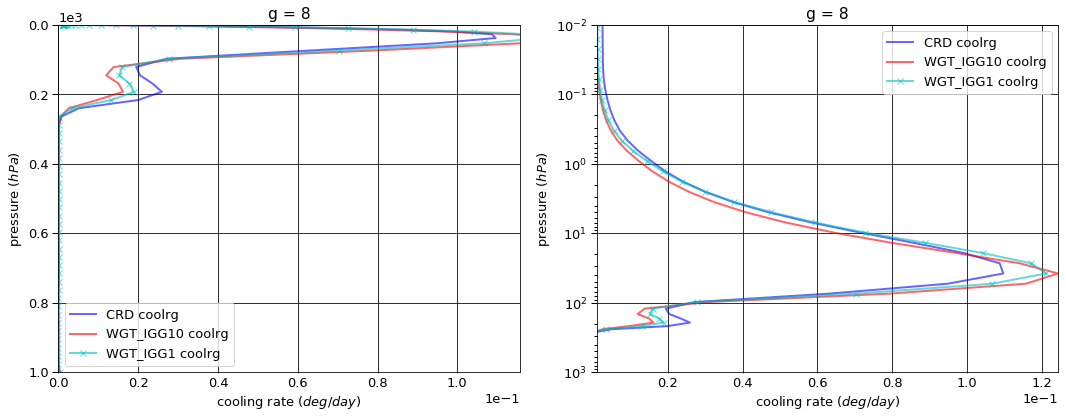

# Figure: cooling rate g-group 9

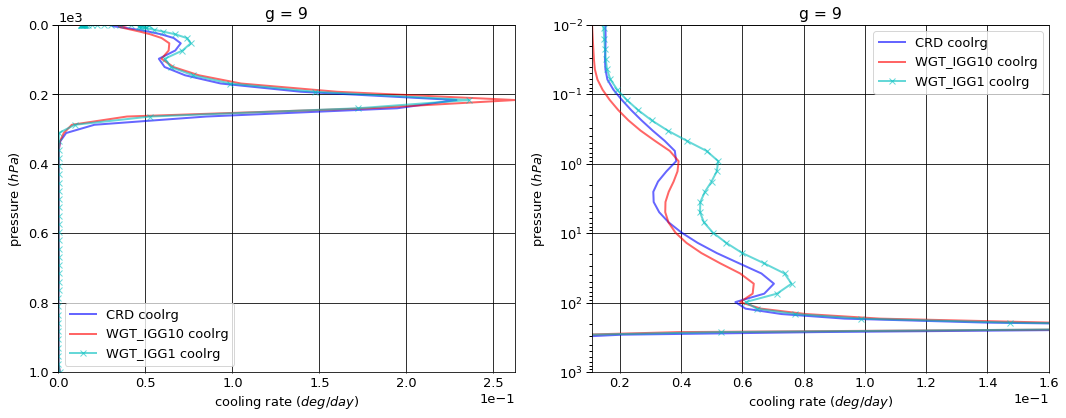

# Figure: cooling rate g-group 10

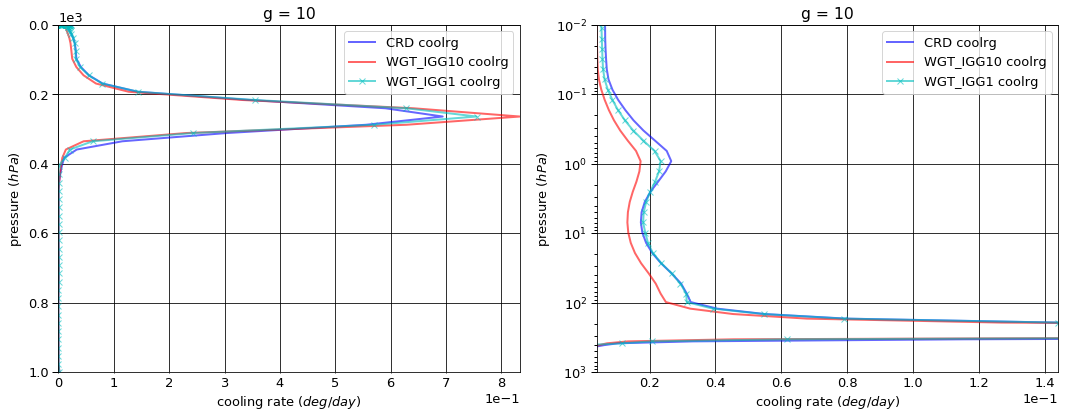

# Figure: cooling rate g-group 11

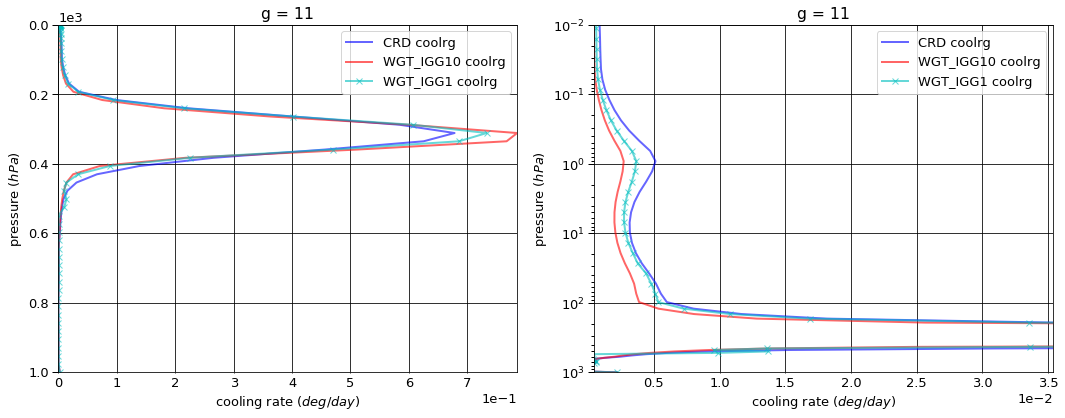

# Figure: cooling rate g-group 12

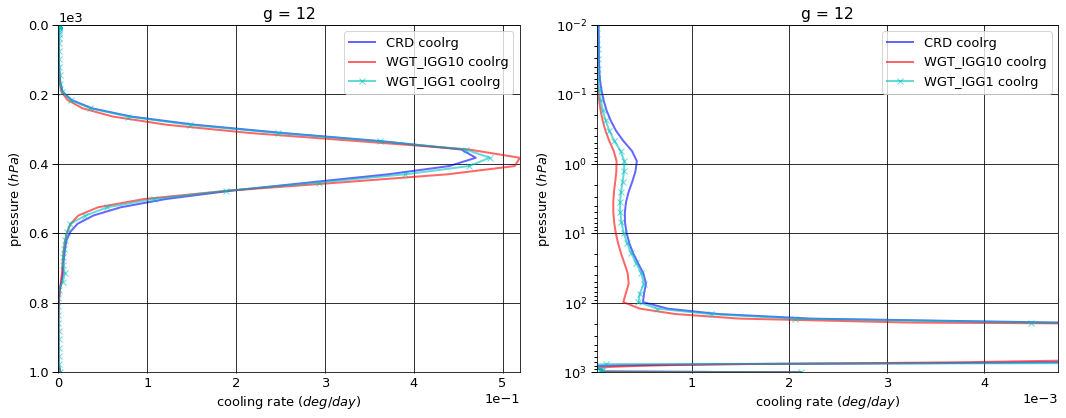

# Figure: cooling rate g-group total

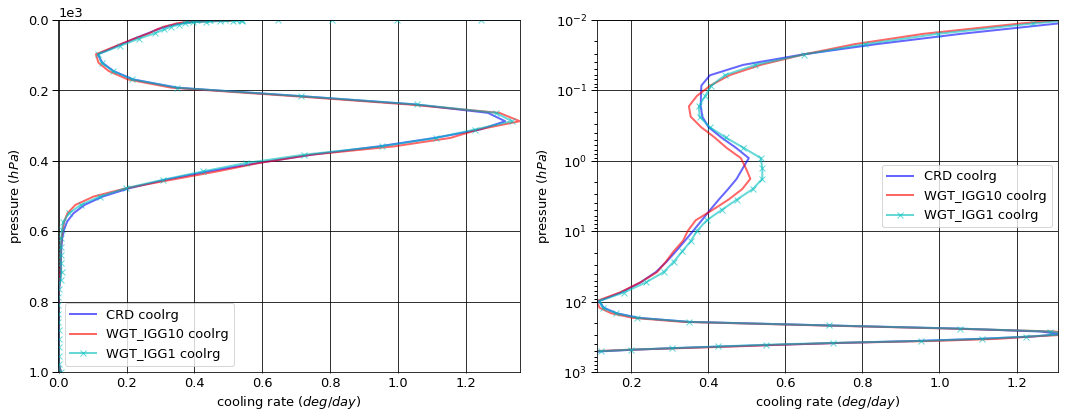

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001845   0.000000  -0.001845
   1013.0   76     -0.003282   0.003281  -0.000001
2  0.0      1      -0.006814   0.000000  -0.006814
   1013.0   76     -0.011508   0.011503  -0.000004
3  0.0      1      -0.015451   0.000000  -0.015451
   1013.0   76     -0.021517   0.021509  -0.000008
4  0.0      1      -0.026743   0.000000  -0.026743
   1013.0   76     -0.033444   0.033432  -0.000012
5  0.0      1      -0.114813   0.000000  -0.114813
   1013.0   76     -0.154051   0.153995  -0.000056
6  0.0      1      -0.263402   0.000000  -0.263402
   1013.0   76     -0.391907   0.391765  -0.000143
7  0.0      1      -0.425700   0.000000  -0.425700
   1013.0   76     -0.709530   0.709273  -0.000257
8  0.0      1      -1.252454   0.000000  -1.252454
   1013.0   76     -2.286743   2.285915  -0.000828
9  0.0      1      -3.323353   0.000000  -3.323353
   1013.0   76     -5.813139   5.811030  -0.002109
10 0.0      1      -8.769954   0.000000  -8.769954
   1013.0   76    -13.953925  13.948809  -0.005116
11 0.0      1     -10.459297   0.000000 -10.459297
   1013.0   76    -15.629408  15.623388  -0.006020
12 0.0      1      -9.673173   0.000000  -9.673173
   1013.0   76    -13.855931  13.850048  -0.005883


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001843   0.000000  -0.001843
   1013.0   76     -0.003282   0.003281  -0.000001
2  0.0      1      -0.006681   0.000000  -0.006681
   1013.0   76     -0.011508   0.011503  -0.000004
3  0.0      1      -0.015618   0.000000  -0.015618
   1013.0   76     -0.021517   0.021509  -0.000008
4  0.0      1      -0.027023   0.000000  -0.027023
   1013.0   76     -0.033444   0.033432  -0.000012
5  0.0      1      -0.116740   0.000000  -0.116740
   1013.0   76     -0.154051   0.153995  -0.000056
6  0.0      1      -0.265627   0.000000  -0.265627
   1013.0   76     -0.391907   0.391765  -0.000143
7  0.0      1      -0.429914   0.000000  -0.429914
   1013.0   76     -0.709530   0.709273  -0.000257
8  0.0      1      -1.238852   0.000000  -1.238852
   1013.0   76     -2.286743   2.285915  -0.000828
9  0.0      1      -3.289670   0.000000  -3.289670
   1013.0   76     -5.813139   5.811030  -0.002109
10 0.0      1      -8.777144   0.000000  -8.777144
   1013.0   76    -13.953925  13.948809  -0.005116
11 0.0      1     -10.462229   0.000000 -10.462229
   1013.0   76    -15.629408  15.623388  -0.006020
12 0.0      1      -9.705278   0.000000  -9.705278
   1013.0   76    -13.855931  13.850057  -0.005874


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001844   0.000000  -0.001844
   1013.0   76     -0.003282   0.003281  -0.000001
2  0.0      1      -0.006717   0.000000  -0.006717
   1013.0   76     -0.011508   0.011503  -0.000004
3  0.0      1      -0.015609   0.000000  -0.015609
   1013.0   76     -0.021517   0.021509  -0.000008
4  0.0      1      -0.026926   0.000000  -0.026926
   1013.0   76     -0.033444   0.033432  -0.000012
5  0.0      1      -0.116502   0.000000  -0.116502
   1013.0   76     -0.154051   0.153995  -0.000056
6  0.0      1      -0.265502   0.000000  -0.265502
   1013.0   76     -0.391907   0.391765  -0.000143
7  0.0      1      -0.429500   0.000000  -0.429500
   1013.0   76     -0.709530   0.709273  -0.000257
8  0.0      1      -1.246322   0.000000  -1.246322
   1013.0   76     -2.286743   2.285915  -0.000828
9  0.0      1      -3.285592   0.000000  -3.285592
   1013.0   76     -5.813139   5.811030  -0.002109
10 0.0      1      -8.726734   0.000000  -8.726734
   1013.0   76    -13.953925  13.948809  -0.005116
11 0.0      1     -10.413051   0.000000 -10.413051
   1013.0   76    -15.629408  15.623388  -0.006020
12 0.0      1      -9.659923   0.000000  -9.659923
   1013.0   76    -13.855931  13.850057  -0.005874


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1      0.000001  0.000000e+00  1.388900e-06
   1013.0   76     0.000000  0.000000e+00 -2.117582e-22
2  0.0      1      0.000133  0.000000e+00  1.327096e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
3  0.0      1     -0.000166  0.000000e+00 -1.664410e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1     -0.000280  0.000000e+00 -2.795510e-04
   1013.0   76     0.000000  6.938894e-18  0.000000e+00
5  0.0      1     -0.001927  0.000000e+00 -1.927020e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
6  0.0      1     -0.002226  0.000000e+00 -2.225510e-03
   1013.0   76     0.000000 -5.551115e-17  0.000000e+00
7  0.0      1     -0.004215  0.000000e+00 -4.214990e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1      0.013602  0.000000e+00  1.360220e-02
   1013.0   76     0.000000  4.440892e-16  0.000000e+00
9  0.0      1      0.033683  0.000000e+00  3.368310e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
10 0.0      1     -0.007190  0.000000e+00 -7.190300e-03
   1013.0   76     0.000000  1.776357e-15  0.000000e+00
11 0.0      1     -0.002932  0.000000e+00 -2.932000e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
12 0.0      1     -0.032105  0.000000e+00 -3.210490e-02
   1013.0   76     0.000000  9.000000e-06  9.031000e-06


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      7.485000e-07  0.000000e+00  7.485000e-07
   1013.0   76     0.000000e+00  0.000000e+00 -2.117582e-22
2  0.0      1      9.681970e-05  0.000000e+00  9.681970e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -1.577260e-04  0.000000e+00 -1.577260e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -1.830850e-04  0.000000e+00 -1.830850e-04
   1013.0   76     0.000000e+00  6.938894e-18  0.000000e+00
5  0.0      1     -1.688440e-03  0.000000e+00 -1.688440e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1     -2.099780e-03  0.000000e+00 -2.099780e-03
   1013.0   76     0.000000e+00 -5.551115e-17  0.000000e+00
7  0.0      1     -3.800320e-03  0.000000e+00 -3.800320e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      6.132100e-03  0.000000e+00  6.132100e-03
   1013.0   76     0.000000e+00  4.440892e-16  0.000000e+00
9  0.0      1      3.776070e-02  0.000000e+00  3.776070e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      4.321990e-02  0.000000e+00  4.321990e-02
   1013.0   76     0.000000e+00  1.776357e-15  0.000000e+00
11 0.0      1      4.624600e-02  0.000000e+00  4.624600e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
12 0.0      1      1.325010e-02  0.000000e+00  1.325010e-02
   1013.0   76     0.000000e+00  9.000000e-06  9.031000e-06

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      3.932732e+00
   1001.112500 75     4.222762e-07
2  0.000312    1      1.339811e+00
   1001.112500 75     1.558845e-06
3  0.000312    1      1.818579e-01
   1001.112500 75     2.864347e-06
4  0.000312    1      1.015378e-04
   1001.112500 75     4.290446e-06
5  0.000312    1      1.841901e-03
   1001.112500 75     2.029711e-05
6  0.000312    1      8.867125e-03
   1001.112500 75     5.139753e-05
7  0.000312    1      2.225633e-04
   1001.112500 75     9.254533e-05
8  0.000312    1      2.380246e-03
   1001.112500 75     2.981693e-04
9  0.000312    1      1.362641e-02
   1001.112500 75     7.594111e-04
10 0.000312    1      5.524949e-03
   1001.112500 75     1.842344e-03
11 0.000312    1      7.227701e-04
   1001.112500 75     2.167547e-03
12 0.000312    1      3.047823e-05
   1001.112500 75     2.118656e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.463746e+00
   1001.112500 75     4.222762e-07
2  0.000312    1      7.321361e-01
   1001.112500 75     1.558845e-06
3  0.000312    1      7.739482e-02
   1001.112500 75     2.864347e-06
4  0.000312    1      1.018529e-04
   1001.112500 75     4.290446e-06
5  0.000312    1      1.706567e-03
   1001.112500 75     2.029711e-05
6  0.000312    1      3.756179e-03
   1001.112500 75     5.139753e-05
7  0.000312    1      1.915305e-04
   1001.112500 75     9.254533e-05
8  0.000312    1      8.858866e-04
   1001.112500 75     2.981693e-04
9  0.000312    1      9.650168e-03
   1001.112500 75     7.594111e-04
10 0.000312    1      3.341954e-03
   1001.112500 75     1.842344e-03
11 0.000312    1      3.606771e-04
   1001.112500 75     2.167547e-03
12 0.000312    1      1.425084e-05
   1001.112500 75     2.114462e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.762043e+00
   1001.112500 75     4.222762e-07
2  0.000312    1      8.837433e-01
   1001.112500 75     1.558845e-06
3  0.000312    1      1.003933e-01
   1001.112500 75     2.864347e-06
4  0.000312    1      1.255162e-04
   1001.112500 75     4.290446e-06
5  0.000312    1      1.983976e-03
   1001.112500 75     2.029711e-05
6  0.000312    1      4.275990e-03
   1001.112500 75     5.139753e-05
7  0.000312    1      2.203203e-04
   1001.112500 75     9.254533e-05
8  0.000312    1      1.021737e-03
   1001.112500 75     2.981693e-04
9  0.000312    1      1.289521e-02
   1001.112500 75     7.594111e-04
10 0.000312    1      4.638436e-03
   1001.112500 75     1.842344e-03
11 0.000312    1      5.056503e-04
   1001.112500 75     2.167547e-03
12 0.000312    1      2.051477e-05
   1001.112500 75     2.114462e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.468986e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -6.076751e-01
   1001.112500 75     2.117582e-22
3  0.000312    1     -1.044631e-01
   1001.112500 75     0.000000e+00
4  0.000312    1      3.151300e-07
   1001.112500 75     8.470329e-22
5  0.000312    1     -1.353342e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -5.110946e-03
   1001.112500 75     0.000000e+00
7  0.000312    1     -3.103278e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.494359e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -3.976243e-03
   1001.112500 75     0.000000e+00
10 0.000312    1     -2.182995e-03
   1001.112500 75     0.000000e+00
11 0.000312    1     -3.620929e-04
   1001.112500 75    -4.336809e-19
12 0.000312    1     -1.622738e-05
   1001.112500 75    -4.193800e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.170690e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.560678e-01
   1001.112500 75     2.117582e-22
3  0.000312    1     -8.146459e-02
   1001.112500 75     0.000000e+00
4  0.000312    1      2.397843e-05
   1001.112500 75     8.470329e-22
5  0.000312    1      1.420745e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -4.591135e-03
   1001.112500 75     0.000000e+00
7  0.000312    1     -2.243040e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.358509e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -7.312000e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -8.865124e-04
   1001.112500 75     0.000000e+00
11 0.000312    1     -2.171198e-04
   1001.112500 75    -4.336809e-19
12 0.000312    1     -9.963452e-06
   1001.112500 75    -4.193800e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.332999,0.000000,-34.332999
1013.0,76,-52.864385,52.843948,-0.020437



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.336620,0.000000,-34.336620
1013.0,76,-52.864385,52.843957,-0.020428



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.194222,0.000000,-34.194222
1013.0,76,-52.864385,52.843957,-0.020428



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.003621,0.000000,-0.003621
1013.0,76,0.000000,0.000009,0.000009



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.138777,0.000000,0.138777
1013.0,76,0.000000,0.000009,0.000009


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.487719
1001.112500,75,0.007360



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.293286
1001.112500,75,0.007355



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,3.771867
1001.112500,75,0.007355



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.194433
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.715853
1001.112500,75,-0.000004


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000072,0.000064
2,0.000222,0.000220
3,0.000466,0.000413
4,0.000716,0.000650
5,0.003416,0.002969
6,0.008944,0.007564
7,0.015216,0.013716
8,0.054069,0.044218
9,0.134259,0.112332


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.008873e-16
2,7.670263e-17
3,1.174574e-17
4,2.908125e-17
5,4.811102e-18
6,7.959323e-19
7,1.130903e-18
8,1.928796e-19
9,3.289633e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.008873e-16,NaN,0.000072,0.000064,0.000072,0.000064,1.0
2,7.670263e-17,0.153134,0.000222,0.000220,0.000294,0.000283,1.0
3,1.174574e-17,0.153134,0.000466,0.000413,0.000759,0.000697,1.0
4,2.908125e-17,2.475897,0.000716,0.000650,0.001475,0.001347,30.0
5,4.811102e-18,0.165437,0.003416,0.002969,0.004891,0.004315,30.0
6,7.959323e-19,0.165437,0.008944,0.007564,0.013834,0.011879,30.0
7,1.130903e-18,1.420853,0.015216,0.013716,0.029050,0.025595,300.0
8,1.928796e-19,0.170554,0.054069,0.044218,0.083119,0.069813,300.0
9,3.289633e-20,0.170554,0.134259,0.112332,0.217378,0.182145,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
